In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ames-housing-dataset/AmesHousing.csv


# **Libraries**

In [2]:
import pandas as pd
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor


# **Dataset Loading**

In [3]:
# Try to load from Kaggle path
if os.path.exists('/kaggle/input/ames-housing-dataset/AmesHousing.csv'):
    path = '/kaggle/input/ames-housing-dataset/AmesHousing.csv'
# Else, load from local repo (for example, if running locally or in Colab)
else:
    path = 'data/AmesHousing.csv'

# Load dataset
df = pd.read_csv(path)

# **Step 1: Dataset Overview**

In [4]:
# Display dataset shape
print("Dataset shape:", df.shape)

# Display data types count
print("\nData types in dataset:\n")
print(df.dtypes.value_counts())

# Display number of missing values (sorted)
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

print("\nMissing values in dataset:\n")
print(missing_values)

# Basic statistics summary of numerical features
print("\nBasic statistics of numerical features:")
print(df.describe())

# Show first few rows of the dataset
df.head()


Dataset shape: (2930, 82)

Data types in dataset:

object     43
int64      28
float64    11
Name: count, dtype: int64

Missing values in dataset:

Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Mas Vnr Type      1775
Fireplace Qu      1422
Lot Frontage       490
Garage Cond        159
Garage Qual        159
Garage Finish      159
Garage Yr Blt      159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Cond           80
Bsmt Qual           80
BsmtFin Type 1      80
Mas Vnr Area        23
Bsmt Half Bath       2
Bsmt Full Bath       2
BsmtFin SF 1         1
Garage Cars          1
Garage Area          1
Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 2         1
Electrical           1
dtype: int64

Basic statistics of numerical features:
            Order           PID  MS SubClass  Lot Frontage       Lot Area  \
count  2930.00000  2.930000e+03  2930.000000   2440.000000    2930.000000   
mean   1465.50000  7.14

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


# **Step 2: Dataset Cleaning (Handeling Missing Values)**



1. Drop columns with too many missing values
2. Fill categorical NaNs with "None
3. Fill numerical NaNs with 0
4. Fill Lot Frontage with the median



In [5]:
# Drop columns with too many missing values
df.drop(columns=["Pool QC", "Misc Feature", "Alley", "Fence"], inplace=True)

# Fill categorical NaNs with "None"
categorical_cols_fill_none = [
    "Mas Vnr Type", "Fireplace Qu", "Garage Type", "Garage Finish",
    "Garage Qual", "Garage Cond", "Bsmt Exposure", "BsmtFin Type 1",
    "BsmtFin Type 2", "Bsmt Cond", "Bsmt Qual", "Electrical"
]
for col in categorical_cols_fill_none:
    df[col] = df[col].fillna("None")

# Fill numerical NaNs with 0 (where appropriate)
numerical_cols_fill_zero = [
    "Mas Vnr Area", "Garage Yr Blt", "Bsmt Half Bath", "Bsmt Full Bath",
    "BsmtFin SF 1", "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF",
    "Garage Cars", "Garage Area"
]
for col in numerical_cols_fill_zero:
    df[col] = df[col].fillna(0)

# Optionally fill Lot Frontage with the median (more meaningful than mean)
df["Lot Frontage"] = df["Lot Frontage"].fillna(df["Lot Frontage"].median())


# **Step 3: Encoding Categorical Features**

In [6]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=["object"]).columns

# One-Hot Encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# **Step 4: Drop irrelevant ID-like columns**

In [7]:
# Drop irrelevant ID-like columns
columns_to_drop = ['Order', 'PID']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# **Step 5: Define Target and Features**

In [8]:
# Define target and features
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]

# **Step 6: Spiliting Data into Train and Test**

In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# **Step 7: Model Fitting: Linear Regression**

In [10]:
# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

LinearRegression()

# Model Prediction on Test Data 

In [11]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Linear Regression Evaluationg

In [12]:
# R² score
r2 = r2_score(y_test, y_pred)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Print the evaluation metrics
print(f"R² score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")


R² score: 0.8952
Mean Absolute Error (MAE): 16247.9553
Mean Squared Error (MSE): 840470670.0811


# **Step 7: Model Fitting: Random Forest**

In [13]:
# Create and fit the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

# Model Prediction on Test Data

In [14]:
# Predict
y_pred_rf = rf_model.predict(X_test)

# Random Forest Evaluating

In [15]:
# Evaluation
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print(f"Random Forest R² score: {r2_rf:.4f}")
print(f"Random Forest MAE: {mae_rf:.4f}")
print(f"Random Forest MSE: {mse_rf:.4f}")


Random Forest R² score: 0.9110
Random Forest MAE: 15701.4665
Random Forest MSE: 713948886.7678


# **Step 8: Model Fitting: XGBoost**

In [16]:
# Define model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Fit the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Model Prediction on Test Data

In [17]:
# Predict
y_pred_xgb = xgb_model.predict(X_test)

# XGBoost Evaluating

In [18]:
# Evaluate
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

print(f"XGBoost R² score: {r2_xgb:.4f}")
print(f"XGBoost MAE: {mae_xgb:.4f}")
print(f"XGBoost MSE: {mse_xgb:.4f}")

XGBoost R² score: 0.9100
XGBoost MAE: 16028.7800
XGBoost MSE: 721542683.5073


# **Finding Top important Features**

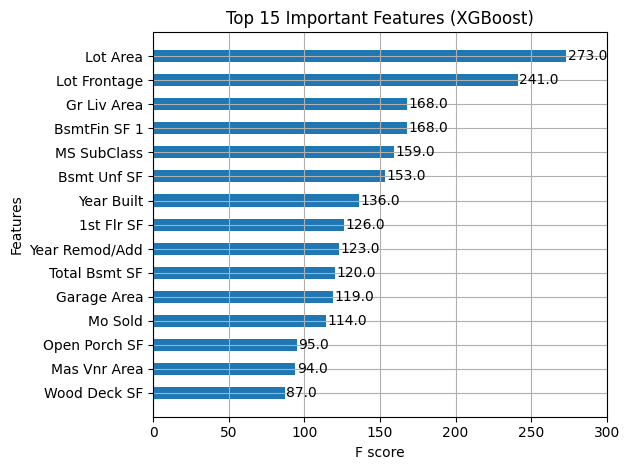

In [19]:
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(xgb_model, max_num_features=15, height=0.5)
plt.title("Top 15 Important Features (XGBoost)")
plt.tight_layout()

# Save the figure
plt.savefig("/kaggle/working/feature_importance.png")
plt.show()